In [1]:
import arviz as az
import pandas as pd
import json
import os

import numpy as np
import diffrax
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import seaborn as sns
import jax
import sys
from scipy.stats import mannwhitneyu, ks_2samp
from tqdm import tqdm


sys.path.append("../models/")
from orton_2009 import *
# Rap1 models
from shin_2014_Rap1 import *
from ryu_2015_Rap1 import *
from vonKriegsheim_2009_Rap1 import *

jax.config.update("jax_enable_x64", True)

sys.path.insert(0, '../')
from utils import *

rng = np.random.default_rng(seed=1234)

# directories
datadir = '../../../results/MAPK/param_est/Keyes_2020_data_locDiffs/'
savedir = '../../../results/MAPK/mmi/Keyes_2020_data_locDiffs/'


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load data and set up the colors

In [14]:
# load in the model info 
model_info = json.load(open('../param_est/model_info.json', 'r'))
model_names = {'orton_2009':['all_diff', 'Rap1_diff', 'p90RsKSoS_diff', 'p90RsKSoS_Rap1_diff'],
                    'shin_2014':['all_diff', 'Rap1_diff', 'Sos_diff', 'Sos_Rap1_diff'],
                    'ryu_2015':['all_diff', 'Rap1_diff', 'DUSP_diff', 'DUSP_Rap1_diff'],}

m_names = ['orton_2009_all_diff',
 'shin_2014_all_diff',
 'ryu_2015_all_diff',
 'orton_2009_Rap1_diff',
 'shin_2014_Rap1_diff',
 'ryu_2015_Rap1_diff',
 'orton_2009_p90RsKSoS_diff',
 'shin_2014_Sos_diff',
 'ryu_2015_DUSP_diff',
 'orton_2009_p90RsKSoS_Rap1_diff',
 'shin_2014_Sos_Rap1_diff',
 'ryu_2015_DUSP_Rap1_diff']

# load in the training data
data_file = '../../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-'

inputs_CYTO, data_CYTO, data_std_CYTO, times_CYTO \
    = load_data_json(data_file+'CYTO_CYTOmax.json', data_std=True, time=True)
inputs_PM, data_PM, data_std_PM, times_PM \
    = load_data_json(data_file+'PM_PMmax.json', data_std=True, time=True)

data_file = '../../../results/MAPK/Keyes_et_al_2020-fig3-data1-v2-'
inputs_CYTO_RAP1i, data_CYTO_RAP1i, data_std_CYTO_RAP1i, \
    times_CYTO_RAP1i = load_data_json(data_file+'CYTO_RAP1inhib_CYTOmax.json', \
    data_std=True, time=True)
inputs_PM_RAP1i, data_PM_RAP1i, data_std_PM_RAP1i, times_PM_RAP1i \
    = load_data_json(data_file+'PM_RAP1inhib_PMmax.json', \
    data_std=True, time=True)

data_time_to_mins = 60

# data in each compartment are sampled at slightly different times, so we need to interpolate to align them
# use diffrax linear interpolation to get the MAPK activity at specific time point over 40mins
data_CYTO_interp = diffrax.LinearInterpolation(times_CYTO, data_CYTO)
data_std_CYTO_interp = diffrax.LinearInterpolation(times_CYTO, data_std_CYTO)
data_PM_interp = diffrax.LinearInterpolation(times_PM, data_PM)
data_std_PM_interp = diffrax.LinearInterpolation(times_PM, data_std_PM)

data_CYTO_RAP1i_interp = diffrax.LinearInterpolation(times_CYTO_RAP1i, \
    data_CYTO_RAP1i)
data_std_CYTO_RAP1i_interp = diffrax.LinearInterpolation(times_CYTO_RAP1i,\
    data_std_CYTO_RAP1i)
data_PM_RAP1i_interp = diffrax.LinearInterpolation(times_PM_RAP1i, data_PM_RAP1i)
data_std_PM_RAP1i_interp = diffrax.LinearInterpolation(times_PM_RAP1i, \
    data_std_PM_RAP1i)

min_time = np.round(np.min([times_CYTO[-1], times_PM[-1], times_CYTO_RAP1i[-1], times_PM_RAP1i[-1]]))
n_times = np.max([len(times_CYTO), len(times_PM), len(times_CYTO_RAP1i), len(times_PM_RAP1i)])
times = np.linspace(0, min_time, n_times)

# get data at standard times
data = {
    'CYTO':data_CYTO_interp.evaluate(times),
    'PM':data_PM_interp.evaluate(times),
    'CYTO_Rap1KD':data_CYTO_RAP1i_interp.evaluate(times),
    'PM_Rap1KD':data_PM_RAP1i_interp.evaluate(times)}

data_std = {
    'CYTO':data_std_CYTO_interp.evaluate(times),
    'PM':data_std_PM_interp.evaluate(times),
    'CYTO_Rap1KD':data_std_CYTO_RAP1i_interp.evaluate(times),
    'PM_Rap1KD':data_std_PM_RAP1i_interp.evaluate(times)}

# set up colors
colors = ["#40004b","#762a83","#9970ab","#c2a5cf","#e7d4e8","#f7f7f7","#d9f0d3","#a6dba0","#5aae61","#1b7837"]
mmi_cols = [list(mpl.colors.to_rgb(col)) + [1.] for col in ['#363737','#929591','#d8dcd6']]
nodes = np.linspace(0, 1, len(colors))
mymap = LinearSegmentedColormap.from_list('mycolors', list(zip(nodes, colors)))
colors = mymap(np.linspace(0, 1, 12))
color_dict = {m_names[i]:colors[i] for i in range(len(m_names))}
colors = np.concatenate((colors, mmi_cols), axis=0) # 12 PRGn colors + 3 MMI colors (grayscale)

colors = get_color_pallette()
color_dict = {m_names[i]:colors[i] for i in range(len(m_names))}

Load all model info

In [15]:
# storage dictionaries
idata = {}
posterior_pred_samples = {}
ss = {}

for idx, model in enumerate(model_names.keys()):
    for submodel in model_names[model]:
        name = datadir + model + '/' + submodel + '/'
        if model in ['shin_2014', 'ryu_2015']:
            model_ = model + '_Rap1'
        else:
            model_ = model
        key = model + '_' + submodel

        # load in the posterior idata
        idata[key], ss[key] = load_smc_samples_to_idata(name + submodel + '_' + model_ + '_smc_samples.json')
        

        # load in the posterior predictive samples
        posterior_pred_samples[key] = {
        'CYTO': np.load(name + submodel + '_' + model_ + '_CYTO_posterior_predictive_samples.npy'),
        'PM': np.load(name + submodel + '_' + model_ + '_PM_posterior_predictive_samples.npy'),
        'CYTO_Rap1KD': np.load(name + submodel + '_' + model_ + \
                                     '_CYTO_Rap1KD_posterior_predictive_samples.npy'),
        'PM_Rap1KD': np.load(name + submodel + '_' + model_ + \
                                     '_PM_Rap1KD_posterior_predictive_samples.npy')}
        
# log marginal likelihoods
log_marginal_likes = {}
log_marginal_likes['orton_2009_all_diff'] = np.mean([chain[-1] for chain in ss['orton_2009_all_diff']['log_marginal_likelihood']])
log_marginal_likes['orton_2009_Rap1_diff'] = np.mean([chain[-1] for chain in ss['orton_2009_Rap1_diff']['log_marginal_likelihood'][0]])
log_marginal_likes['orton_2009_p90RsKSoS_diff'] = np.mean([chain[-1] for chain in ss['orton_2009_p90RsKSoS_diff']['log_marginal_likelihood']])
log_marginal_likes['orton_2009_p90RsKSoS_Rap1_diff'] = np.mean([chain[-1] for chain in ss['orton_2009_p90RsKSoS_Rap1_diff']['log_marginal_likelihood']])
log_marginal_likes['shin_2014_all_diff'] = np.mean([chain[-1] for chain in ss['shin_2014_all_diff']['log_marginal_likelihood'][0]])
log_marginal_likes['shin_2014_Rap1_diff'] = np.mean([chain[-1] for chain in ss['shin_2014_Rap1_diff']['log_marginal_likelihood'][0]])
log_marginal_likes['shin_2014_Sos_diff'] = np.mean([chain[-1] for chain in ss['shin_2014_Sos_diff']['log_marginal_likelihood']])
log_marginal_likes['shin_2014_Sos_Rap1_diff'] = np.mean([chain[-1] for chain in ss['shin_2014_Sos_Rap1_diff']['log_marginal_likelihood'][0]])
log_marginal_likes['ryu_2015_all_diff'] = np.mean([chain[-1] for chain in ss['ryu_2015_all_diff']['log_marginal_likelihood'][0]])
log_marginal_likes['ryu_2015_Rap1_diff'] = np.mean([chain[-1] for chain in ss['ryu_2015_Rap1_diff']['log_marginal_likelihood'][0]])
log_marginal_likes['ryu_2015_DUSP_diff'] = np.mean([chain[-1] for chain in ss['ryu_2015_DUSP_diff']['log_marginal_likelihood'][0]])
log_marginal_likes['ryu_2015_DUSP_Rap1_diff'] = np.mean([chain[-1] for chain in ss['ryu_2015_DUSP_Rap1_diff']['log_marginal_likelihood'][0]])

Now compute LOO-CV, and stacking weights for all models together

In [16]:
idata_modified = {}
for key in idata.keys():
    log_like = idata[key].log_likelihood
    llike = np.concatenate((log_like['llike_CYTO'].values, log_like['llike_PM'].values, log_like['llike_CYTO_Rap1KD'].values, log_like['llike_PM_Rap1KD'].values), axis=3)
    coords = {'chains':np.arange(4), 'draws':np.arange(500), 'llike_dim_0':np.arange(1), 'llike_dim_1':np.arange(llike.shape[3])}
    temp = az.from_dict(log_likelihood={'llike':llike}, 
                        coords=coords)
    temp.add_groups({'posterior':idata[key].posterior,
                     'observed_data':idata[key].observed_data,
                     'constant_data':idata[key].constant_data})
    idata_modified[key] = temp

Now compute everything that we need to MMI

In [17]:
compare_data_loo_pbma = az.compare(idata_modified, ic='loo', method='BB-pseudo-BMA', seed=rng)
compare_data_loo_stack = az.compare(idata_modified, ic='loo', method='stacking', seed=rng)

# compute model probabilities
# function to compute log sum exponential in a numerically stable way
def logsumexp(x):
    c = np.max(x)
    return c + np.log(np.sum(np.exp(x - c)))

def weight_with_logsumexp(log_values):
    return np.exp(log_values - logsumexp(log_values))

model_probs = {}
n_models = len(log_marginal_likes.keys())
prior_prob = 1/n_models
log_marg_likes = np.array(list(log_marginal_likes.values()))
m_prob = weight_with_logsumexp(np.log(prior_prob)+log_marg_likes)
model_probs = {key:m_prob[i] for i, key in enumerate(log_marginal_likes.keys())}

/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc

Plot ELPD estimates, model probs and weights

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_58355/1205557429.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_58355/1205557429.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)


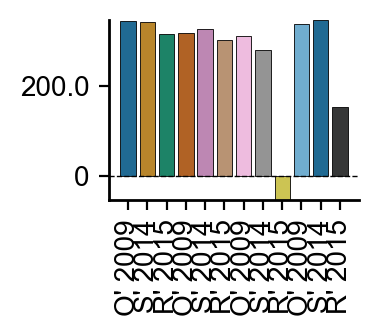

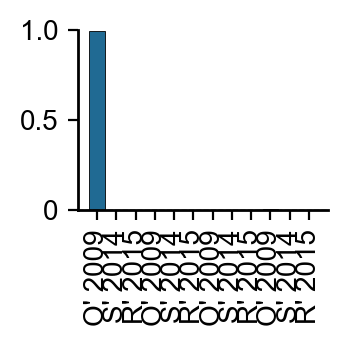

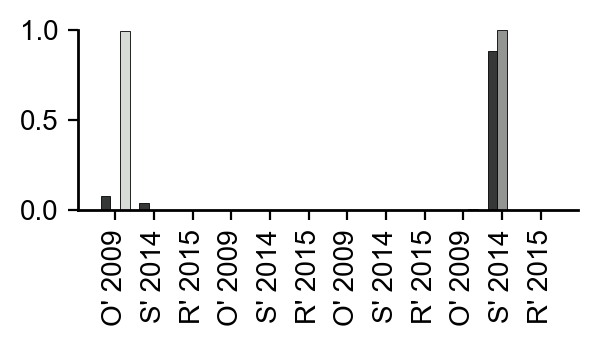

In [18]:
m_names = ['orton_2009_all_diff',
 'shin_2014_all_diff',
 'ryu_2015_all_diff',
 'orton_2009_Rap1_diff',
 'shin_2014_Rap1_diff',
 'ryu_2015_Rap1_diff',
 'orton_2009_p90RsKSoS_diff',
 'shin_2014_Sos_diff',
 'ryu_2015_DUSP_diff',
 'orton_2009_p90RsKSoS_Rap1_diff',
 'shin_2014_Sos_Rap1_diff',
 'ryu_2015_DUSP_Rap1_diff']

# display_names = ["O' 2009 all diff.", "S' 2014 all diff.", "R' 2015 all diff.",
                # "O' 2009 Rap1 diff.", "S' 2014 Rap1 diff.", "R' 2015 Rap1 diff.",
                # "O' 2009 (-)feedback diff.", "S' 2014 (-)feedback diff.", "R' 2015 (-)feedback diff.",
                # "O' 2009 Rap1 & (-)feedback diff.","S' 2014 Rap1 & (-)feedback diff.", "R' 2015 Rap1 & (-)feedback diff."] 
display_names = ["O' 2009", "S' 2014", "R' 2015",
                "O' 2009", "S' 2014", "R' 2015",
                "O' 2009", "S' 2014", "R' 2015",
                "O' 2009","S' 2014", "R' 2015"] 

_colors = [color_dict[model] for model in m_names]

# ELPD
dat = [compare_data_loo_pbma['elpd_loo'][model] for model in m_names]
fig, ax = get_sized_fig_ax(1.25, 0.9)
bar = ax.bar(m_names, dat, edgecolor='k')
ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
for i, br in enumerate(bar):
    br.set_facecolor(_colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
ax.set_ylim([0.25*np.min(dat), np.max(dat)])
ax.set_yticks([0, 200.0])
ax.set_yticklabels([0, 200.0], fontsize=10.0)
fig.savefig(savedir + 'all_models_elpd_loo.pdf', transparent=True)

# Model probs
dat = [model_probs[model] for model in m_names]
fig, ax = get_sized_fig_ax(1.25, 0.9)
bar = ax.bar(m_names, dat, edgecolor='k')
ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
for i, br in enumerate(bar):
    br.set_facecolor(_colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
ax.set_ylim([0, 1.0])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels([0, 0.5, 1.0], fontsize=10.0)
fig.savefig(savedir + 'all_models_model_probs.pdf', transparent=True)

# model weights
x = np.arange(n_models)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

stack = [compare_data_loo_stack['weight'][model] for model in m_names]
pBMA = [compare_data_loo_pbma['weight'][model] for model in m_names]
bma = [model_probs[model] for model in m_names]

fig, ax = get_sized_fig_ax(2.5, 0.9)
for dat, name, col in zip([pBMA, stack, bma], ['pseudo-BMA','stacking','BMA',], [colors[-3], colors[-2], colors[-1]]):
    offset = width * multiplier
    bar = ax.bar(x + offset, dat, width, label=name, color=col, edgecolor='k')
    # ax.bar_label(bar, padding=3)
    multiplier += 1

# ax.set_ylabel('model weight', fontsize=12)
ax.set_xticks(x + width, display_names)
ax.set_yticks([0.0, 0.5, 1.0])
ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=10.0)
leg = ax.legend(loc='center', fontsize=10.0, bbox_to_anchor=(0.5, 1.3), ncol=1)
leg.remove()

# ax.set_ylabel(r'weight', fontsize=12)
ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
ax.set_ylim([0, 1.0])
fig.savefig(savedir  + 'all_models_model_weights.pdf', transparent=True)

Now repeat without the all diff models

In [19]:
idata_no_all_diff = {}
log_marginal_likes_no_all_diff = {}
for key in idata_modified.keys():
    if 'all_diff' not in key:
        idata_no_all_diff[key] = idata_modified[key]
        log_marginal_likes_no_all_diff[key] = log_marginal_likes[key]
print(idata_no_all_diff.keys())

compare_data_loo_pbma_no_all_diff = az.compare(idata_no_all_diff, ic='loo', method='BB-pseudo-BMA', seed=rng)
compare_data_loo_stack_no_all_diff = az.compare(idata_no_all_diff, ic='loo', method='stacking', seed=rng)

# compute model probabilities
# function to compute log sum exponential in a numerically stable way
def logsumexp(x):
    c = np.max(x)
    return c + np.log(np.sum(np.exp(x - c)))

def weight_with_logsumexp(log_values):
    return np.exp(log_values - logsumexp(log_values))

model_probs_no_all_diff = {}
n_models = len(log_marginal_likes_no_all_diff.keys())
prior_prob = 1/n_models
log_marg_likes = np.array(list(log_marginal_likes_no_all_diff.values()))
m_prob = weight_with_logsumexp(np.log(prior_prob)+log_marg_likes)
model_probs_no_all_diff = {key:m_prob[i] for i, key in enumerate(log_marginal_likes_no_all_diff.keys())}

dict_keys(['orton_2009_Rap1_diff', 'orton_2009_p90RsKSoS_diff', 'orton_2009_p90RsKSoS_Rap1_diff', 'shin_2014_Rap1_diff', 'shin_2014_Sos_diff', 'shin_2014_Sos_Rap1_diff', 'ryu_2015_Rap1_diff', 'ryu_2015_DUSP_diff', 'ryu_2015_DUSP_Rap1_diff'])


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_58355/3435096937.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_58355/3435096937.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)


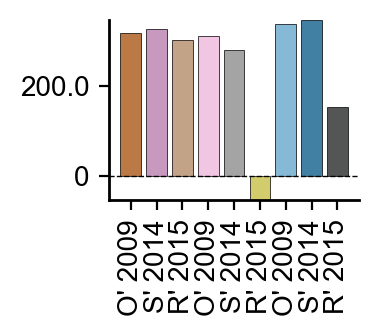

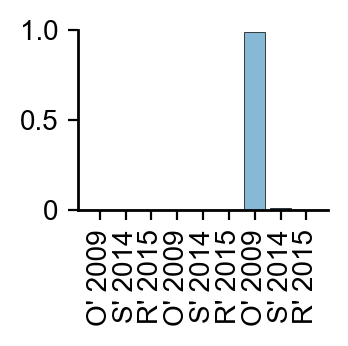

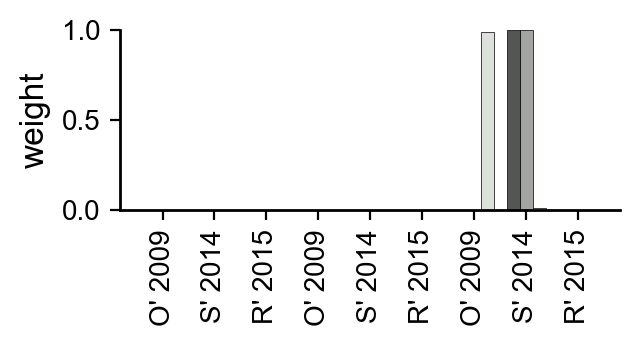

In [41]:
m_names = [
 'orton_2009_Rap1_diff',
 'shin_2014_Rap1_diff',
 'ryu_2015_Rap1_diff',
 'orton_2009_p90RsKSoS_diff',
 'shin_2014_Sos_diff',
 'ryu_2015_DUSP_diff',
 'orton_2009_p90RsKSoS_Rap1_diff',
 'shin_2014_Sos_Rap1_diff',
 'ryu_2015_DUSP_Rap1_diff']

# display_names = [ "O' 2009 Rap1 diff.", "S' 2014 Rap1 diff.", "R' 2015 Rap1 diff.",
                # "O' 2009 (-)feedback diff.", "S' 2014 (-)feedback diff.", "R' 2015 (-)feedback diff.",
                # "O' 2009 Rap1 & (-)feedback diff.", "S' 2014 Rap1 & (-)feedback diff.", "R' 2015 Rap1 & (-)feedback diff."]
display_names = [ "O' 2009", "S' 2014", "R' 2015",
                "O' 2009", "S' 2014", "R' 2015",
                "O' 2009", "S' 2014", "R' 2015"] 

_colors = [color_dict[model] for model in m_names]

# ELPD
dat = [compare_data_loo_pbma_no_all_diff['elpd_loo'][model] for model in m_names]
fig, ax = get_sized_fig_ax(1.25, 0.9)
bar = ax.bar(m_names, dat, edgecolor='k', alpha=0.85)
ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
for i, br in enumerate(bar):
    br.set_facecolor(_colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
ax.set_ylim([0.25*np.min(dat), np.max(dat)])
ax.set_yticks([0, 200.0])
ax.set_yticklabels([0, 200.0], fontsize=10.0)
fig.savefig(savedir + 'no_all_diff_models_elpd_loo.pdf', transparent=True)

# Model probs
dat = [model_probs_no_all_diff[model] for model in m_names]
fig, ax = get_sized_fig_ax(1.25, 0.9)
bar = ax.bar(m_names, dat, edgecolor='k', alpha=0.85)
ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
for i, br in enumerate(bar):
    br.set_facecolor(_colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
ax.set_ylim([0, 1.0])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels([0, 0.5, 1.0], fontsize=10.0)
fig.savefig(savedir + 'no_all_diff_models_model_probs.pdf', transparent=True)

# model weights
x = np.arange(9)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

stack = [compare_data_loo_stack_no_all_diff['weight'][model] for model in m_names]
pBMA = [compare_data_loo_pbma_no_all_diff['weight'][model] for model in m_names]
bma = [model_probs_no_all_diff[model] for model in m_names]

fig, ax = get_sized_fig_ax(2.5, 0.9)
for dat, name, col in zip([pBMA, stack, bma], ['pBMA','stacking','BMA',], [colors[-3], colors[-2], colors[-1]]):
    offset = width * multiplier
    bar = ax.bar(x + offset, dat, width, label=name, color=col, edgecolor='k', alpha=0.85)
    # ax.bar_label(bar, padding=3)
    multiplier += 1

ax.set_ylabel('model weight', fontsize=12)
ax.set_xticks(x + width, display_names)
ax.set_yticks([0.0, 0.5, 1.0])
ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=10.0)
leg = ax.legend(loc='center', fontsize=8.0, bbox_to_anchor=(0.5, 1.3), ncol=1)
leg.remove()

ax.set_ylabel(r'weight', fontsize=12)
ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
ax.set_ylim([0, 1.0])
fig.savefig(savedir  + 'no_all_diff_models_model_weights.pdf', transparent=True)

In [42]:
m_names = [
 'orton_2009_Rap1_diff',
 'shin_2014_Rap1_diff',
 'ryu_2015_Rap1_diff',
 'orton_2009_p90RsKSoS_diff',
 'shin_2014_Sos_diff',
 'ryu_2015_DUSP_diff',]

idata_no_all_diff_no_rapneg = {}
log_marginal_likes_no_all_diff_no_rapneg = {}
exclude = ['orton_2009_all_diff', 'shin_2014_all_diff', 'ryu_2015_all_diff', 'orton_2009_p90RsKSoS_Rap1_diff', 'shin_2014_Sos_Rap1_diff', 'ryu_2015_DUSP_Rap1_diff']
for key in idata_modified.keys():
    if key not in exclude:
        idata_no_all_diff_no_rapneg[key] = idata_modified[key]
        log_marginal_likes_no_all_diff_no_rapneg[key] = log_marginal_likes[key]
print(idata_no_all_diff_no_rapneg.keys())

compare_data_loo_pbma_no_all_diff_no_rapneg = az.compare(idata_no_all_diff_no_rapneg, ic='loo', method='BB-pseudo-BMA', seed=rng)
compare_data_loo_stack_no_all_diff_no_rapneg = az.compare(idata_no_all_diff_no_rapneg, ic='loo', method='stacking', seed=rng)

# compute model probabilities
# function to compute log sum exponential in a numerically stable way
def logsumexp(x):
    c = np.max(x)
    return c + np.log(np.sum(np.exp(x - c)))

def weight_with_logsumexp(log_values):
    return np.exp(log_values - logsumexp(log_values))

model_probs_no_all_diff_no_rapneg = {}
n_models = len(log_marginal_likes_no_all_diff_no_rapneg.keys())
prior_prob = 1/n_models
log_marg_likes = np.array(list(log_marginal_likes_no_all_diff_no_rapneg.values()))
m_prob = weight_with_logsumexp(np.log(prior_prob)+log_marg_likes)
model_probs_no_all_diff_no_rapneg = {key:m_prob[i] for i, key in enumerate(log_marginal_likes_no_all_diff_no_rapneg.keys())}

dict_keys(['orton_2009_Rap1_diff', 'orton_2009_p90RsKSoS_diff', 'shin_2014_Rap1_diff', 'shin_2014_Sos_diff', 'ryu_2015_Rap1_diff', 'ryu_2015_DUSP_diff'])


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_58355/3562962018.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_58355/3562962018.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)


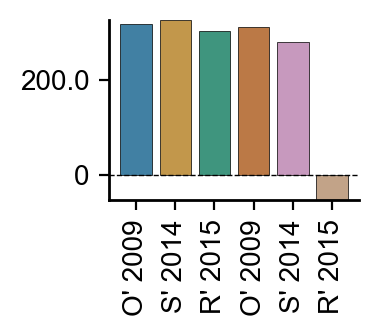

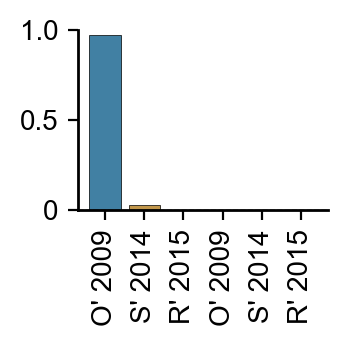

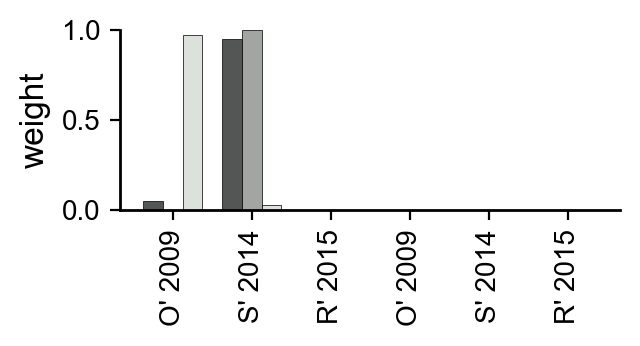

In [32]:
m_names = [
 'orton_2009_Rap1_diff',
 'shin_2014_Rap1_diff',
 'ryu_2015_Rap1_diff',
 'orton_2009_p90RsKSoS_diff',
 'shin_2014_Sos_diff',
 'ryu_2015_DUSP_diff',]

# display_names = ["O' 2009 Rap1 diff.", "S' 2014 Rap1 diff.", "R' 2015 Rap1 diff.",
#                 "O' 2009 (-)feedback diff.", "S' 2014 (-)feedback diff.", "R' 2015 (-)feedback diff.",] 
display_names = ["O' 2009", "S' 2014", "R' 2015",
                "O' 2009", "S' 2014", "R' 2015",] 

# ELPD
dat = [compare_data_loo_pbma_no_all_diff_no_rapneg['elpd_loo'][model] for model in m_names]
fig, ax = get_sized_fig_ax(1.25, 0.9)
bar = ax.bar(m_names, dat, edgecolor='k', alpha=0.85)
ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
ax.set_ylim([0.25*np.min(dat), np.max(dat)])
ax.set_yticks([0, 200.0])
ax.set_yticklabels([0, 200.0], fontsize=10.0)
fig.savefig(savedir + 'no_all_diff_no_rapneg_models_elpd_loo.pdf', transparent=True)

# Model probs
dat = [model_probs_no_all_diff_no_rapneg[model] for model in m_names]
fig, ax = get_sized_fig_ax(1.25, 0.9)
bar = ax.bar(m_names, dat, edgecolor='k', alpha=0.85)
ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
ax.set_ylim([0, 1.0])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels([0, 0.5, 1.0], fontsize=10.0)
fig.savefig(savedir + 'no_all_diff_no_rapneg_models_model_probs.pdf', transparent=True)

# model weights
x = np.arange(n_models)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

stack = [compare_data_loo_stack_no_all_diff_no_rapneg['weight'][model] for model in m_names]
pBMA = [compare_data_loo_pbma_no_all_diff_no_rapneg['weight'][model] for model in m_names]
bma = [model_probs_no_all_diff_no_rapneg[model] for model in m_names]

fig, ax = get_sized_fig_ax(2.5, 0.9)
for dat, name, col in zip([pBMA, stack, bma], ['pseudo-BMA','stacking','BMA',], [colors[-3], colors[-2], colors[-1]]):
    offset = width * multiplier
    bar = ax.bar(x + offset, dat, width, label=name, color=col, edgecolor='k', alpha=0.85)
    # ax.bar_label(bar, padding=3)
    multiplier += 1

ax.set_ylabel('model weight', fontsize=12)
ax.set_xticks(x + width, display_names)
ax.set_yticks([0.0, 0.5, 1.0])
ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=10.0)
leg = ax.legend(loc='center', fontsize=8.0, bbox_to_anchor=(0.5, 1.3), ncol=1)
leg.remove()

ax.set_ylabel(r'weight', fontsize=12)
ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
ax.set_ylim([0, 1.0])
fig.savefig(savedir  + 'no_all_diff_no_rapneg_models_model_weights.pdf', transparent=True)

#### Plot eCDF of Rap1 and (-)feedback parameters in the Rap1 & (-)feedback models

In [33]:
np.array(idata['shin_2014_Sos_Rap1_diff'].posterior['ki39_CYTO'].stack(sample=['chain', 'draw']))

array([3.83800452e-06, 1.95237871e-06, 2.49928423e-03, ...,
       9.59946370e-05, 2.65114934e-05, 1.19985889e-04])

Stats for orton_2009_p90RsKSoS_Rap1_diff, parameter k1_C3G_Deactivation
Mann-Whitney p<0.05: True (p=0.000000e+00 )
 KS:True (p=0.000000e+00)
Stats for orton_2009_p90RsKSoS_Rap1_diff, parameter k1_P90Rsk_Deactivation
Mann-Whitney p<0.05: True (p=0.000000e+00 )
 KS:True (p=0.000000e+00)
Stats for orton_2009_p90RsKSoS_Rap1_diff, parameter k1_Sos_Deactivation
Mann-Whitney p<0.05: True (p=1.767493e-52 )
 KS:True (p=4.345077e-50)
Stats for shin_2014_Sos_Rap1_diff, parameter ki39
Mann-Whitney p<0.05: True (p=0.000000e+00 )
 KS:True (p=1.057863e-268)
Stats for shin_2014_Sos_Rap1_diff, parameter kRap1_RafAct
Mann-Whitney p<0.05: True (p=0.000000e+00 )
 KS:True (p=0.000000e+00)


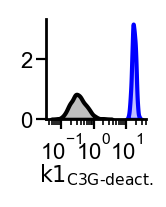

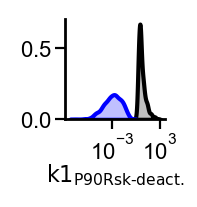

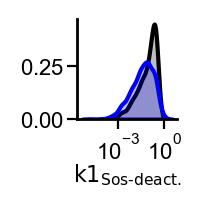

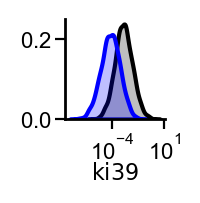

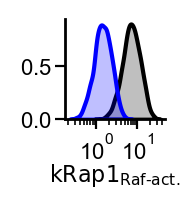

In [34]:
params = {'orton_2009_p90RsKSoS_Rap1_diff':['k1_C3G_Deactivation', 'k1_P90Rsk_Deactivation', 'k1_Sos_Deactivation'],
          'shin_2014_Sos_Rap1_diff':['ki39', 'kRap1_RafAct']}

display_names = [r'$k1_{C3G\text{-}deact.}$',r'$k1_{P90Rsk\text{-}deact.}$',r'$k1_{Sos\text{-}deact.}$',  r'$ki39$', r'$kRap1_{Raf\text{-}act.}$']

disp_name_idx = 0
for model in params.keys():
    for i, param in enumerate(params[model]):
            fig, ax = get_sized_fig_ax(0.5,0.5)
        
            cyto = np.array(idata[model].posterior[param + '_CYTO'].stack(sample=['chain', 'draw']))
            pm = np.array(idata[model].posterior[param + '_PM'].stack(sample=['chain', 'draw']))
            
            # plot eCDFs of CYTO and PM
            dat = pd.DataFrame({'CYTO':cyto, 'PM':pm})
            # sns.ecdfplot(dat, ax=ax, 
                        # palette=['blue', 'black'], 
                        # legend=False, linewidth=1.5)
            sns.kdeplot(dat, ax=ax, 
                        palette=['blue', 'black'], 
                        legend=False, linewidth=1.5, log_scale=(True, False), fill=True)
            # xlim = ax.get_xlim()
            
            # plot setup
            ax.tick_params(axis='both', which='major', labelsize=8.0, pad=1.25)
            ax.set_ylabel('', fontsize=10.0)
            ax.set_xlabel(display_names[disp_name_idx], fontsize=8.0, labelpad=-0.75)    

            # save the figure
            fig.savefig(savedir + model + '_' + param + '_cyto_vs_pm.pdf', transparent=True, bbox_inches='tight')

            # compute stats and print
            mwu = mannwhitneyu(cyto, pm, alternative='two-sided')
            ks = ks_2samp(cyto, pm, alternative='two-sided')
            text = 'Mann-Whitney p<0.05: {mw} (p={pmw:.6e} )\n KS:{ks} (p={pks:.6e})'.format(mw=mwu.pvalue<0.05, ks=ks.pvalue<0.05, pmw=mwu.pvalue, pks=ks.pvalue)
            print('Stats for {mod}, parameter {param}'.format(mod=model, param=param) + '\n' + text)
            disp_name_idx += 1

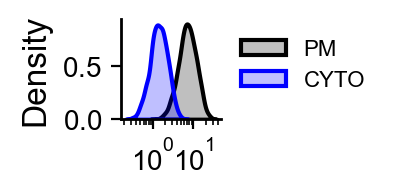

In [25]:
fig, ax = get_sized_fig_ax(0.5,0.5)
dat = pd.DataFrame({'CYTO':cyto, 'PM':pm})
            # sns.ecdfplot(dat, ax=ax, 
                        # palette=['blue', 'black'], 
                        # legend=False, linewidth=1.5)
sns.kdeplot(dat, ax=ax, 
    palette=['blue', 'black'], 
    legend=False, linewidth=1.5, log_scale=(True, False), fill=True)

leg = ax.legend(['PM', 'CYTO'], loc='upper left', fontsize=8.0, bbox_to_anchor=(1.0, 1.0), ncol=1)
export_legend(leg, filename=savedir + 'displot_legend.pdf')